In [117]:
import arff
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from src.medidas_desempeno_biclase import calcula_medidas_biclase
from src.matriz_biclase import imprime_matriz_biclase

import time
from src.cnn import CNN

# 1.- Dataset sin balancear

In [118]:
with open('data/2year.arff') as f:
    dataset = arff.load(f)

df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])
#df = df.dropna()
print(f'df.shape: {df.shape}')
df.head()

df.shape: (10173, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,0.253660,0.545610,0.178650,0.25366,603.20,0.605110,2.1505,0.25366,0.161050,42.697,1.0806,0.223490,0.128480,0.63105,0.426950,0.494780,1.6345,0.815590,6.0038,0.22803,0.161050,124.100,2.94120,0.48063,0.223490,1.62580,5095.3000,0.42705,0.14190,0.464890,0.060856,0.14190,113.36,70.661,1.09830,1.12070,49.181,0.195770,0.12430,1.51670,0.46490,0.34000,1.4486,1.4490,242500.0,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,0.042199,0.075493,0.145630,0.04167,4613.90,0.079109,1.6789,0.04167,0.128780,239.120,NaN,0.042196,0.092943,NaN,0.029802,0.059639,79.7520,0.714320,4.0672,1.80520,0.128780,708.740,0.51499,0.47725,0.039298,0.32356,NaN,0.40437,0.12146,0.028211,0.416710,0.13041,815.69,576.570,0.14187,0.95419,272.170,0.036746,0.11357,1.24010,0.55197,1.94180,1.5473,1.5473,2179.5,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,0.324530,1.064400,0.197450,0.31877,330.29,1.105100,3.3390,0.31877,0.190170,84.246,1.1146,0.304660,0.153830,NaN,0.607750,0.901690,52.8860,18.836000,3.7415,0.14756,0.190210,78.101,4.67340,4.67340,0.276560,1.67620,NaN,0.69841,0.16499,0.179420,0.031507,0.18175,198.36,114.110,0.66649,1.92920,100.890,0.292470,0.17448,3.22110,0.29949,0.21398,19.7770,19.7770,3668.6,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,0.381070,0.551560,0.227940,0.28505,820.52,0.444840,1.4738,0.28505,0.215270,69.778,1.2704,0.379470,0.171560,NaN,0.309750,0.359520,3.9521,0.097146,4.4738,0.48944,0.221940,201.670,1.80990,1.37860,0.388740,1.32410,1.9671,0.47729,0.29358,0.087377,0.057077,0.28658,141.81,72.028,0.89740,0.59298,98.777,0.362700,0.27392,0.82475,0.51680,0.55251,0.7300,1.0837,1273.8,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,0.108230,0.284520,0.089326,0.10823,997.01,0.366100,2.6289,0.10823,0.069422,63.995,1.3596,0.188340,0.054807,0.22602,0.521670,0.306200,1.3442,1.379700,4.7049,0.19682,0.069422,99.090,3.68350,0.49514,0.188340,1.63470,NaN,0.52167,0.12081,0.201730,0.057007,0.12081,155.20,91.204,0.31259,1.22580,71.204,0.157310,0.10091,1.94440,0.38039,0.27148,2.0035,2.0035,18209.0,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


In [119]:
print('Cardinalidad Polish Companies Bankruptcy')
print(df['class'].value_counts())
mayor = df['class'].value_counts().max()
menor = df['class'].value_counts().min()
print(f'IR: {np.round(mayor/menor, 2)}')

Cardinalidad Polish Companies Bankruptcy
class
0    9773
1     400
Name: count, dtype: int64
IR: 24.43


### Imputar valores nulos

In [120]:
print(df.isna().sum().sum())

12157


In [121]:
for col in df.columns:
    if df[col].dtype == 'object':
        imputer = SimpleImputer(strategy = 'most_frequent')
    else:
        imputer = SimpleImputer(strategy = 'mean')
    df[[col]] = imputer.fit_transform(df[[col]])

In [122]:
print(df.isna().sum().sum())
print(df.shape)

0
(10173, 65)


### Partición

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('class', axis=1),
    df['class'],
    test_size=0.2,
    stratify=df['class'],
    random_state=42)

encoder_df = LabelEncoder()
y_train = encoder_df.fit_transform(y_train)
y_test = encoder_df.transform(y_test)

### Entrenar SVM

In [124]:
svm_model = svm.SVC()
resultados_svm_original = []
cv = 30
params = {'kernel' : ['linear'],
    'C': [3],
    'gamma': [0.0002]}

medidas = {
        'balanced_accuracy': 'balanced_accuracy'}

grid = GridSearchCV(
    estimator = svm_model,
    param_grid = params,
    cv = cv,
    scoring = medidas,
    refit = 'balanced_accuracy',
    n_jobs = -1)

grid.fit(X_train, y_train)
resultados_svm_original.append({
    'cv': cv,
    'best_score': grid.best_score_,
    'best_params': grid.best_params_, 
    'medidas': grid.cv_results_})

svm_model = grid.best_estimator_
    
print(f"Modelo SVM con kernel={svm_model.kernel} y C={svm_model.C}")

NameError: name 'svm' is not defined

### Entrenar una Regresión Logística

In [ ]:
rl_model = LogisticRegression()

rl_model.fit(X_train, y_train)
y_predicciones = rl_model.predict(X_test)
y_probabilidades = rl_model.predict_proba(X_test)

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Entrenar un Random Forest en dataset original

In [ ]:
rfmodel = RandomForestClassifier()
cv_vals = [5, 10, 15]
resultados = []

params = {'n_estimators' : [100, 200, 300],
          'min_samples_split' : [3, 5, 7],
          'max_features' : ['sqrt']}

medidas = {'balanced_accuracy': 'balanced_accuracy'}

for cval in cv_vals:    
    grid = GridSearchCV(
        estimator = rfmodel,
        param_grid = params,
        cv = cval,
        scoring = medidas,
        refit = 'balanced_accuracy',
        n_jobs = -1)

    grid.fit(X_train, y_train)
    resultados.append({
        'cv': cval,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_, 
        'medidas': grid.cv_results_})

rfmodel = grid.best_estimator_

df_resultados = pd.DataFrame(resultados)
df_resultados.head()

,cv,best_score,best_params,medidas
0,5,0.639744,"{'max_features': 'sqrt', 'min_samples_split': ...","{'mean_fit_time': [2.1550957679748537, 4.23176..."
1,10,0.628185,"{'max_features': 'sqrt', 'min_samples_split': ...","{'mean_fit_time': [2.8935548782348635, 5.48781..."
2,15,0.633164,"{'max_features': 'sqrt', 'min_samples_split': ...","{'mean_fit_time': [2.6531985282897947, 5.38490..."


In [ ]:
rfmodel.fit(X_train, y_train)

y_predicciones = rfmodel.predict(X_test)
y_probabilidades = rfmodel.predict_proba(X_test)

df_resultados_rf = calcula_medidas_biclase(
    y_test,
    y_predicciones)
print(df_resultados_rf.head(10))

imprime_matriz_biclase(y_test, y_predicciones)

                 Medida     Valor
0              Accuracy  0.968550
1            Error Rate  0.031450
2  Recall (Sensitivity)  0.237500
3           Specificity  0.998465
4     Balanced Accuracy  0.617983
5             Precision  0.863636
6              F1 Score  0.372549
7                   MCC  0.443439


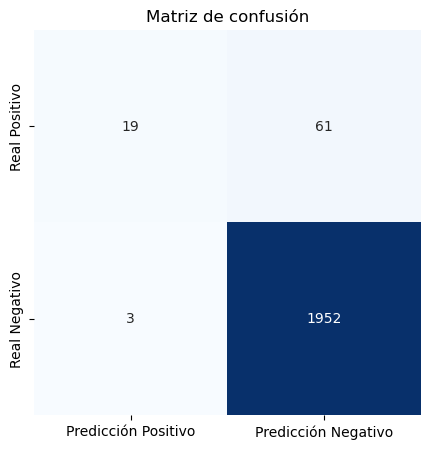

In [ ]:
rf_model = RandomForestClassifier(n_estimators=300,
                                  random_state=42,
                                  min_samples_split = 3,
                                  max_features= 'sqrt')
rf_model.fit(X_train, y_train)

y_predicciones = rf_model.predict(X_test)
y_probabilidades = rf_model.predict_proba(X_test)

df_resultados_rf = calcula_medidas_biclase(
    y_test,
    y_predicciones)
print(df_resultados_rf.head(10))

imprime_matriz_biclase(y_test, y_predicciones)

# 2.- Dataset balanceado con CNN

In [ ]:
print(df.shape)
df.head()

(10173, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,0.253660,0.545610,0.178650,0.25366,603.20,0.605110,2.1505,0.25366,0.161050,42.697,1.080600,0.223490,0.128480,0.631050,0.426950,0.494780,1.6345,0.815590,6.0038,0.22803,0.161050,124.100,2.94120,0.48063,0.223490,1.62580,5095.30000,0.42705,0.14190,0.464890,0.060856,0.14190,113.36,70.661,1.09830,1.12070,49.181,0.195770,0.12430,1.51670,0.46490,0.34000,1.4486,1.4490,242500.0,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,0.042199,0.075493,0.145630,0.04167,4613.90,0.079109,1.6789,0.04167,0.128780,239.120,2.645024,0.042196,0.092943,0.240073,0.029802,0.059639,79.7520,0.714320,4.0672,1.80520,0.128780,708.740,0.51499,0.47725,0.039298,0.32356,82.94436,0.40437,0.12146,0.028211,0.416710,0.13041,815.69,576.570,0.14187,0.95419,272.170,0.036746,0.11357,1.24010,0.55197,1.94180,1.5473,1.5473,2179.5,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,0.324530,1.064400,0.197450,0.31877,330.29,1.105100,3.3390,0.31877,0.190170,84.246,1.114600,0.304660,0.153830,0.240073,0.607750,0.901690,52.8860,18.836000,3.7415,0.14756,0.190210,78.101,4.67340,4.67340,0.276560,1.67620,82.94436,0.69841,0.16499,0.179420,0.031507,0.18175,198.36,114.110,0.66649,1.92920,100.890,0.292470,0.17448,3.22110,0.29949,0.21398,19.7770,19.7770,3668.6,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,0.381070,0.551560,0.227940,0.28505,820.52,0.444840,1.4738,0.28505,0.215270,69.778,1.270400,0.379470,0.171560,0.240073,0.309750,0.359520,3.9521,0.097146,4.4738,0.48944,0.221940,201.670,1.80990,1.37860,0.388740,1.32410,1.96710,0.47729,0.29358,0.087377,0.057077,0.28658,141.81,72.028,0.89740,0.59298,98.777,0.362700,0.27392,0.82475,0.51680,0.55251,0.7300,1.0837,1273.8,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,0.108230,0.284520,0.089326,0.10823,997.01,0.366100,2.6289,0.10823,0.069422,63.995,1.359600,0.188340,0.054807,0.226020,0.521670,0.306200,1.3442,1.379700,4.7049,0.19682,0.069422,99.090,3.68350,0.49514,0.188340,1.63470,82.94436,0.52167,0.12081,0.201730,0.057007,0.12081,155.20,91.204,0.31259,1.22580,71.204,0.157310,0.10091,1.94440,0.38039,0.27148,2.0035,2.0035,18209.0,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


### Aplicación del algoritmo CNN

In [ ]:
X = df.iloc[:, :-1].values
y = df['class'].values

In [ ]:
inicio = time.time()
print('Iniciando algoritmo Condensed Nearest Neighbors...')
df_cnn = CNN(X, y)
final = time.time()
print('Algoritmo finalizado.')
print(f'Tiempo de ejecución: {round(final - inicio, 4)} segundos')

Iniciando algoritmo Condensed Nearest Neighbors...
Algoritmo finalizado.
Tiempo de ejecución: 270.7209 segundos


In [ ]:
nombres = df.columns
df_cnn.columns = nombres
df_cnn.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.202350,0.46500,0.240380,1.51710,-14.5470,0.510690,0.253660,0.91816,1.15190,0.42695,0.253660,0.545610,0.178650,0.253660,603.2,0.605110,2.1505,0.253660,0.161050,42.6970,1.080600,0.223490,0.128480,0.631050,0.42695,0.494780,1.63450,0.815590,6.0038,0.22803,0.161050,124.100,2.9412,0.48063,0.223490,1.62580,5095.30000,0.42705,0.141900,0.464890,0.060856,0.141900,113.360,70.6610,1.098300,1.12070,49.1810,0.195770,0.124300,1.51670,0.46490,0.340000,1.44860,1.44900,242500.00,0.131840,0.473950,0.86816,0.00024,8.5487,5.1655,107.740,3.3879,5.3440,0
1,0.003927,0.77496,0.073840,1.09560,-204.2900,-0.015867,0.003927,0.29110,1.16940,0.22559,0.017672,0.005083,0.030420,0.003927,7951.3,0.045905,1.2904,0.003927,0.003358,215.4700,2.645024,0.017031,0.003358,0.003927,-0.01194,0.045905,1.23910,0.479190,3.1014,0.56729,0.006757,244.440,1.5012,1.49660,0.016065,1.17720,82.94436,0.22559,0.013737,0.175020,0.530670,0.014563,221.970,6.5018,0.005689,1.06860,218.4300,-0.014616,-0.012498,1.09220,0.77256,0.669690,1.46400,1.46400,93.26,0.013541,0.017408,0.98518,0.00000,1.6940,56.1380,241.130,1.5137,7.5891,1
2,0.148240,0.47228,0.043866,1.24330,-5.2615,0.381020,0.191200,1.11340,1.09700,0.52585,0.191200,1.060700,0.119220,0.191200,630.3,0.579090,2.1174,0.191200,0.083348,9.8396,0.847230,0.203570,0.064620,0.473370,0.52585,0.488120,0.97354,0.056538,4.5323,0.19033,0.083348,31.466,11.6000,0.43104,0.203570,2.34700,0.55577,0.81786,0.088742,0.261050,0.054316,0.088742,28.175,18.3350,2.397100,0.90029,10.7940,0.121280,0.052869,0.47458,0.18026,0.086208,0.67776,1.05410,1494.30,0.088461,0.281900,0.91154,0.55531,37.0950,19.9070,28.682,12.7260,2.9566,0
3,0.007747,0.79043,-0.203420,0.41452,-77.8050,0.000000,0.010926,0.26514,1.09590,0.20957,0.025626,0.031447,0.014501,0.010926,18154.0,0.020106,1.2651,0.010926,0.009969,9.1300,2.645024,0.014303,0.007069,0.010926,0.18971,0.016084,0.97297,-0.237640,3.7019,0.71869,0.009969,117.780,3.0989,1.36220,0.019269,1.09590,0.26358,0.65197,0.017582,0.010292,1.367400,0.013051,46.775,37.6450,0.282610,0.33562,9.2934,0.009336,0.008519,0.18221,0.34744,0.322690,0.24484,0.76166,-1024.00,0.017582,0.036967,0.99022,2.11090,39.9780,9.6960,115.710,3.1544,1.2803,0
4,-0.027914,0.70986,0.102100,1.29820,7.1565,-0.000114,-0.028885,0.40873,0.98895,0.29014,0.107420,-0.084366,0.032195,-0.028885,8137.6,0.044854,1.4087,-0.028885,-0.029208,30.4060,1.187100,0.027207,-0.028226,0.074842,0.18261,0.046222,0.19961,0.183800,4.9480,0.70455,-0.010027,130.320,2.8007,1.35090,0.030035,0.98895,0.99941,0.65246,0.030371,0.043676,0.269090,0.027511,158.530,128.1300,-0.338840,1.05760,31.3580,-0.033518,-0.033892,0.62617,0.34238,0.357050,0.52230,1.17450,9058.80,0.030371,-0.096209,1.02690,1.24880,12.0040,2.8488,126.370,2.8884,1.7803,0


### Observar nuevas dimensiones

In [ ]:
print('Cardinalidad Polish Companies Bankruptcy CNN')
print(df_cnn['class'].value_counts())
mayor = df_cnn['class'].value_counts().max()
menor = df_cnn['class'].value_counts().min()
print(f'IR: {np.round(mayor/menor, 2)}')

Cardinalidad Polish Companies Bankruptcy CNN
class
0    1413
1     361
Name: count, dtype: int64
IR: 3.91


In [ ]:
print(f"Dimensiones datos    : {df_cnn.drop('class', axis=1).shape}")
print(f"Dimensiones etiquetas: {df_cnn['class'].shape}")

Dimensiones datos    : (1774, 64)
Dimensiones etiquetas: (1774,)


### Partición del conjunto de datos cnn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_cnn.drop('class', axis=1),
    df_cnn['class'],
    test_size=0.2,
    stratify=df_cnn['class'],
    random_state=42)

encoder_cnn = LabelEncoder()
y_train = encoder_cnn.fit_transform(y_train)
y_test = encoder_cnn.transform(y_test)

### Random Forest en el nuevo dataset_cnn

                 Medida     Valor
0              Accuracy  0.828169
1            Error Rate  0.171831
2  Recall (Sensitivity)  0.263889
3           Specificity  0.971731
4     Balanced Accuracy  0.617810
5             Precision  0.703704
6              F1 Score  0.383838
7                   MCC  0.357399


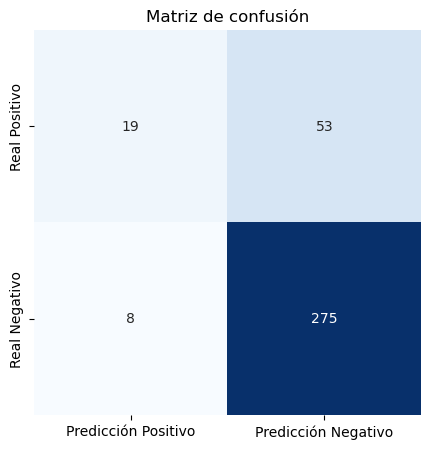

In [ ]:
rf_model = RandomForestClassifier(n_estimators=300,
                                  random_state=42,
                                  min_samples_split = 3,
                                  max_features= 'sqrt')
rf_model.fit(X_train, y_train)

y_predicciones = rf_model.predict(X_test)
y_probabilidades = rf_model.predict_proba(X_test)

df_resultados_rf = calcula_medidas_biclase(
    y_test,
    y_predicciones)
print(df_resultados_rf.head(10))

imprime_matriz_biclase(y_test, y_predicciones)